# CNN for Traffic Sign Classification with TensorFlow 2

- [German Traffic Sign Dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) from the GTSRB competition
- [Paper on applying CNNs to this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)


## Load train, validation, and test data

In [1]:
# Load pickled data
import pickle
import pandas as pd

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# separate X and y
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# load mapping from label number to name of label
signnames = pd.read_csv('signnames.csv')

## Exploratory Data Analysis (EDA)

In [2]:
# summary of data
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
img_shape = X_train[0].shape
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


View some signs and their labels. Though hard to see, they seem to make sense.

Class: Keep right


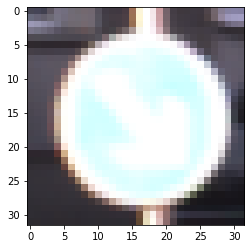

Class: Speed limit (30km/h)


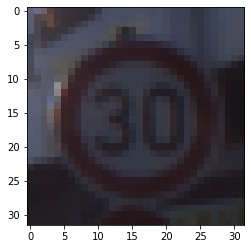

Class: Ahead only


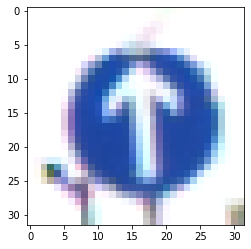

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# view some random training images and their labels
for _ in range(3):
    rand_idx = np.random.randint(0, n_train)
    print('Class:', signnames.iloc[y_train[rand_idx]]['SignName'])
    plt.imshow(X_train[rand_idx])
    plt.show()

View class distribution of the 3 data sets. Although there is some imbalance, the distribution seems similar across the 3 sets.

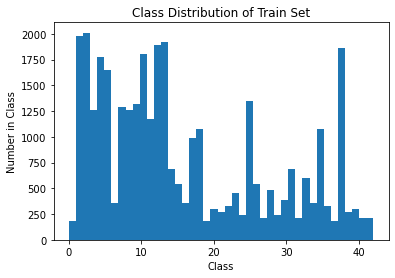

In [4]:
plt.hist(y_train, bins=n_classes)
plt.title('Class Distribution of Train Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.show()

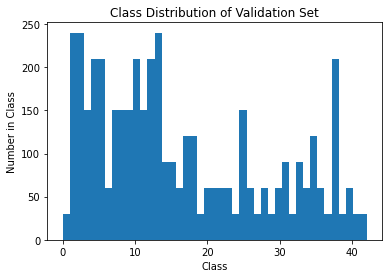

In [5]:
plt.hist(y_valid, bins=n_classes)
plt.title('Class Distribution of Validation Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.show()

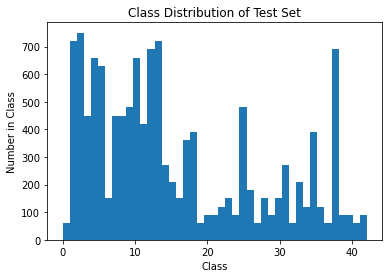

In [6]:
plt.hist(y_test, bins=n_classes)
plt.title('Class Distribution of Test Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.show()

## Pre-Processing

## CNN Model Architecture

Default is the LeNet-5: 
![Lenet-5](lenet.png)

In [7]:
import tensorflow as tf

# some parameters
BATCH_SIZE = 128
EPOCHS = 20

#### Low-level TensorFlow Implementation (similar to TF 1): 

In [8]:
def conv(x, W, b, strides):
    """
    Perform convolution with activation
    
    Args:
        x (np.ndarray): input to be convolved
        W (tf.Variable): weights for the 'Xw' part of Xw + b
        b (tf.Variable): biases for the 'b' part of Xw + b
    """
    conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding="VALID")
    conv = tf.nn.bias_add(conv, b)
    return tf.nn.relu(conv)

def max_pool(x, k, s):
    """
    Perform max pooling
    
    Args:
        x (np.ndarray): input to be pooled
        k (int): kernel size, sometimes referred to as k or F
        s (int): stride length
    """
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding="VALID")

In [9]:
random_normal = tf.initializers.RandomNormal()

# 'c' conv, 'f' fully connected

weights = {
    # 32x32x3 => 28x28x6 with a 5x5 filter, stride=1
    'wc1': tf.Variable(random_normal([5, 5, 3, 6])),
    # 14x14x6 => 10x10x16 with 5x5 filter, stride=1
    'wc2': tf.Variable(random_normal([5, 5, 6, 16])),
    # 5x5x16 or 400 => 120
    'wf1': tf.Variable(random_normal([400, 120])),
    # 120 => 84
    'wf2': tf.Variable(random_normal([120, 84])),
    # 84 => 43 classes
    'wf3': tf.Variable(random_normal([84, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bf1': tf.Variable(tf.zeros([120])),
    'bf2': tf.Variable(tf.zeros([84])),
    'bf3': tf.Variable(tf.zeros([n_classes]))
}

In [25]:
def low_net(x):
    """Low-level TF 2 (similar to TF 1) implementation of LeNet"""
    # for weight/bias initialization
    mu = 0
    sigma = 0.1
    
    # first conv layer and pooling
    conv1 = conv(x, weights['wc1'], biases['bc1'], strides=1)  # 28x28x6
    pool1 = max_pool(conv1, k=2, s=2)  # 14x14x6
    out1 = tf.nn.relu(pool1)
    
    # second conv layer and pooling
    conv2 = conv(out1, weights['wc2'], biases['bc2'], strides=1)  # 10x10x16
    pool2 = max_pool(conv2, k=2, s=2)  # 5x5x16
    out2 = tf.nn.relu(pool2)
    
    # flatten from 5x5x16 to 400, weights['wf1'].get_shape().as_list()[0]]
    flattened = tf.reshape(out2, 400)
    
    # first fully connected layer
    fc1 = tf.bias_add(tf.matmul(flattened, weights['wf1']), biases['bf1'])
    fc1 = tf.nn.relu(fc1)
    
    # second fully connected layer
    fc2 = tf.bias_add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
    fc2 = tf.nn.relu(fc2)
    
    # last fc layer (output)
    logits = tf.bias_add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
        
    return logits

#### Using TF 2 `layers` and `model` API:

Quite similar to PyTorch API - contstruct a class inheriting from the `Model` module, define the architecture as a series of functions and implement the forward pass or computational graph by calling the functions in a `call(x)` or `forward(x)` method

In [30]:
from tensorflow.keras import Model, layers

In [37]:
class LeNet(Model):
    def __init__(self):
        """Define the architecture"""
        super(LeNet, self).__init__()
        
        # conv1: 32x32x3 => 28x28x6 with a 5x5 kernel, stride=1
        # NOTE: 'filters' arg is # of feature maps
        self.conv1 = layers.Conv2D(
            filters=6, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 28x28x6 => 14x14x6 with 2x2 kernel, stride=2; 
        self.pool1 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # conv2: 14x14x6 => 10x10x16 with a 5x5 kernel, stride=1
        self.conv2 = layers.Conv2D(
            filters=16, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 10x10x16 => 5x5x16 with 2x2 kernel, stride=2; 
        self.pool2 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # 5x5x16 => 400 to be fed into fully connected layers
        self.flatten = layers.Flatten()
        
        # fully connected layer 1
        self.fc1 = layers.Dense(400, activation='relu')
        
        # TODO: apply dropout 
        
        # fc2
        self.fc2 = layers.Dense(120, activation='relu')
        
        # TODO: apply dropout
        
        # fc3
        self.fc3 = layers.Dense(84, activation='relu')
        
        # output layer
        self.out = layers.Dense(n_classes)
        
    def call(self, x, is_training=False):
        """The forward pass"""
        x = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        if not is_training:
            # only apply softmax when predicting
            # tf CE w/ logits function expects logits for training loss
            x = tf.nn.softmax(x)
        return x

In [38]:
# inst. the model
model = LeNet()

#### Keras / TF2 Implementation

## Evaluation

In [40]:
def cross_entropy_loss(logits, y):
    """Compute cross entropy loss given logits and labels (y)"""
    y = tf.cast(y, tf.int64)
    
    # apply softmax to logits and compute cross entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    # return avg loss across entire batch
    return tf.reduce_mean(loss)

def accuracy(y_pred, y):
    """Compute accuracy given predictions and labels"""
    correct_preds = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64)) # prediction is argmax of logits
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32), axis=-1)

rate = 0.001
optimizer = tf.optimizers.Adam(rate)

In [27]:
# count number of correct predictions
# correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
# accuracy = tf.reduce_mean(correct_predictions)

# def evaluate(X_eval, y_eval):
#     """Used to evaluate accuracy on validation and test"""
#     num_examples = len(X_eval)
#     total_correct = 0
    
#     for offset in range(0, num_examples, BATCH_SIZE):
#         batch_x, batch_y = X_eval[offset:offset+BATCH_SIZE], y_eval[offset:offset+BATCH_SIZE]
        
#         logits = low_next(batch_x)
#         acc = accuracy(logits, batch_y)
        
#         total_correct += (acc * BATCH_SIZE)
        
#     return total_correct / num_examples

## Training

In [41]:
def run_optimization(X, y):
    with tf.GradientTape() as g:
        logits = model(X, is_training=True)
        loss = cross_entropy_loss(logits, y)
        
    parameters = model.trainable_variables
    gradients = g.gradient(loss, parameters)
    optimizer.apply_gradients(zip(gradients, parameters))  # use gradients to update parameters

In [42]:
# training loop
for epoch in range(EPOCHS):
    print(f'EPOCH {epoch+1}')
    num_examples = len(X_train)
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]

        run_optimization(batch_x, batch_y)

        # validate
        valid_accuracy = accuracy(X_valid, y_valid)
        print(f'Valid Accuracy = {valid_accuracy}')

EPOCH 1


InvalidArgumentError: Value for attr 'T' of uint8 is not in the list of allowed values: half, bfloat16, float, double, int32
	; NodeDef: {{node Conv2D}}; Op<name=Conv2D; signature=input:T, filter:T -> output:T; attr=T:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE, DT_INT32]; attr=strides:list(int); attr=use_cudnn_on_gpu:bool,default=true; attr=padding:string,allowed=["SAME", "VALID", "EXPLICIT"]; attr=explicit_paddings:list(int),default=[]; attr=data_format:string,default="NHWC",allowed=["NHWC", "NCHW"]; attr=dilations:list(int),default=[1, 1, 1, 1]> [Op:Conv2D]